In [125]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 

%load_ext autoreload  
%autoreload 2 

import matplotlib.mlab as mlab  # using griddata from here
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata  # never got this to work
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

from scipy.special import sph_harm  # spherical harmonics
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.sph_harm.html

# some color maps
#colormap='gist_ncar'
#colormap='gist_stern'
#colormap='terrain'
colormap='prism'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


this notebook makes the following figures for the Bennu paper
 b1spec.png
 b1cylpost.png 
 b1orthpost.png 
 c2cylpost.png 
 c2orthpost.png 

In [44]:
angfac = 180.0/np.pi # for converting radians to degrees
twopi = np.pi*2.0

# return filename
def getfilename(filerrot,npi):  # file format fileroot_%d.txt
    junk = '.txt'
    zeros = ''
    if (npi<10):
        zeros = zeros+ '0'
    if (npi<100):
        zeros = zeros+ '0'
    if (npi<1000):
        zeros = zeros+ '0'
    if (npi<10000):
        zeros = zeros+ '0'
    filename = "%s_%s%d%s"%(fileroot,zeros,npi,junk)
    return filename

# read in a surface file format fileroot_%d.txt
# I think a surface file only contains nodes near the surface
def readsurffile(fileroot,npi):
    filename=getfilename(fileroot,npi)
    #print(filename)
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm =\
           np.loadtxt(filename, skiprows=1, unpack='true')
    rad = np.sqrt(x*x + y*y + z*z)
    latarr = np.arcsin(z/rad)  # range [-pi/2,pi/2]
    lonarr_neg = np.arctan2(y,x)   # range [-pi,pi]
    lonarr = (lonarr_neg + twopi)%twopi
    vr = (vx*x + vy*y + vz*z)/rad  # radial component of velocity
    ar = (ax*x + ay*y + az*z)/rad  # radial component of acceleration,
    # we could try to add centripetal acceleration for an effective thing?
    return tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar


# read in a file for a single particle as a function of time
# doing this so we can make a spectrum!
# before running this you need to extract the single node information from the outputs
# and put it in a file
def readpfile(filename):
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm =\
           np.loadtxt(filename, skiprows=1, unpack='true')
    rad = np.sqrt(x*x + y*y + z*z)
    latarr = np.arcsin(z/rad)  # range [-pi/2,pi/2]
    lonarr_neg = np.arctan2(y,x)   # range [-pi,pi]
    lonarr = (lonarr_neg + twopi)%twopi
    vr = (vx*x + vy*y + vz*z)/rad
    ar = (ax*x + ay*y + az*z)/rad
    return tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar

# latarr seems to go from -pi/2 to pi/2


In [5]:
# return index of surface particle that is nearest to lat,lon
# returns index of particle with nearest to desired latitude and longitude
def nearest_latlon(filename,npi,lat_deg,lon_deg):
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar = readsurffile(fileroot,npi)
    lat = lat_deg*np.pi/180.0
    lon = lon_deg*np.pi/180.0
    x0 = np.cos(lon)*np.cos(lat)
    y0 = np.sin(lon)*np.cos(lat)
    z0 = np.sin(lat)
    rad = np.sqrt(x*x + y*y + z*z)
    rhatdotr0 = (x*x0 + y*y0 + z*z0)/rad
    angdist = np.arccos(rhatdotr0)  # should be in [0,pi] so always positive
    ii = np.argmin(angdist)
    return ii

# seems to work, this means we can generate p files for specific latitudes
# rather than looking for them in the output tables

In [135]:

# make a png figure showing surface
# projection is lat lon, cylinder map projection 
# zmax sets display range
gridn=50 # sets number of grid points
def mkpngs_cyl(fileroot,npi,npj,zmax,whicharr):
    for i in range(npi,npj):
        # read in surface mass nodes from file
        tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,i)
        
        # Generate a regular grid to interpolate the data.
        lats = np.linspace(-np.pi/2, np.pi/2, gridn) # latitude grid
        lons = np.linspace(0.0, 2*np.pi, 1.5*gridn)  #longitude grid
        lons_i, lats_i = np.meshgrid(lons, lats)
        
        tfilename=getfilename(fileroot,i)

        # Interpolate using delaunay triangularization 
        # vr is the thing we are looking at on the latlon grid
        
        if (whicharr == 'ar'):  # either display accelerations or velocities
            show_arr=ar
            filename = tfilename + '_ar_cyl.png'
        else:
            show_arr=vr
            filename = tfilename + '_vr_cyl.png'
        zi = mlab.griddata(lonarr,latarr,show_arr,lons_i,lats_i, interp='linear')
        # if you use scipy.interopolate.griddata, the keyord is method, not interp
        # I never got this griddata to work, sticking to mlab.griddata

        # Plot the results
        fig=plt.figure(figsize=(8,4))
        plt.pcolormesh(lons_i,lats_i,zi,vmin=-zmax, vmax=zmax, cmap=colormap)
        plt.colorbar()
        plt.axis([0, 2*np.pi, -np.pi/2, np.pi/2])
        
        ylabels = [r'$-\pi/2$','0',r'$\pi/2$']
        plt.yticks([-np.pi/2,0,np.pi/2],ylabels,fontsize=16)
        xlabels = ['0',r'$\pi$',r'$2\pi$']
        plt.xticks([0,np.pi,2*np.pi],xlabels,fontsize=16)
        
        ss = str(i) # output file number
        plt.text(0.1,np.pi/2+0.1,ss,fontsize=16,horizontalalignment='left')
        
        plt.savefig(filename)
        plt.close(fig)
        

# make a png figure showing surface
# projection is perspective, orthographic projection 
# zmax sets display range
def mkpngs_orth(fileroot,npi,npj,zmax,whicharr):
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,0)
    rmax = np.max(np.abs(x))
    # Generate a regular grid to interpolate the data.
    xarr = np.linspace(-rmax, rmax, gridn)
    zarr = np.linspace(-rmax, rmax, gridn)
    xarr_i, zarr_i = np.meshgrid(xarr, zarr)
    for i in range(npi,npj):
        # read in surface nodes from file
        tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,i)
           
        tfilename=getfilename(fileroot,i)
        
        if (whicharr == 'ar'):
            show_arr=ar
            filename = tfilename + '_ar_orth.png'
        else:
            show_arr=vr
            filename = tfilename + '_vr_orth.png'

        yposa = np.where(y>=0)  # for finding front and back
        ynega = np.where(y<=0)
        # Interpolate vr using delaunay triangularization, two sides
        # vr is what we are intepolating
        ypos = mlab.griddata(x[yposa],z[yposa],show_arr[yposa],xarr_i,zarr_i, interp='linear')
        yneg = mlab.griddata(x[ynega],z[ynega],show_arr[ynega],xarr_i,zarr_i, interp='linear')

        # Plot the results
        f,axarr =  plt.subplots(1,2, figsize=(8,5))
        il = 0;  # left panel?
        axarr[il].set_aspect('equal')
        axarr[il].set_xlim([-rmax,rmax])
        axarr[il].set_ylim([-rmax,rmax])
        axarr[il].pcolormesh(xarr_i,zarr_i,ypos,vmin=-zmax, vmax=zmax,cmap=colormap)
        
        ss = str(i)
        axarr[il].text(-1,1.21,ss,fontsize=12,horizontalalignment='left')
        
        il = 1;  # right panel? 
        axarr[il].set_aspect('equal')
        axarr[il].set_xlim([-rmax,rmax])
        axarr[il].set_ylim([-rmax,rmax])
        im = axarr[il].pcolormesh(xarr_i,zarr_i,yneg,vmin=-zmax, vmax=zmax,cmap=colormap)
        #f.subplots_adjust(right=0.8)
        #cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
        #f.colorbar(im, ax=cbar_ax) 
        f.colorbar(im, ax=axarr.ravel().tolist(), shrink=0.58)
         
        plt.savefig(filename)
        plt.close(f)


In [127]:
# make a fig of 12 postage stamps
nx = 2
ny = 6
adjust_right=0.8
dt_output=2e-5*5  # for simulations!
def mkpngs_cyl_post(fileroot,npi,dn,zmin,zmax,whicharr,filename):
    fig,axarr =  plt.subplots(ny, nx,dpi=700, figsize=(4,7), sharex=True,sharey=True) 
    plt.subplots_adjust(left=0.08, right=adjust_right, top=0.91, bottom=0.195, \
        wspace=0.0, hspace=0.0)
    matplotlib.rc('xtick', labelsize=10)
    matplotlib.rc('ytick', labelsize=10) 
    npj = npi + 12*dn
    for i in range(npi,npj,dn): # file output numbers
        k = int((i-npi)/dn)
        ii = k%ny
        jj = int(k/ny)
        #print(i,k,ii,jj)
        
        # read in surface mass nodes from file
        tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,i)
        
        # Generate a regular grid to interpolate the data.
        lonshift = np.pi/2.0
        lats = np.linspace(-np.pi/2, np.pi/2, gridn) # latitude grid
        lons = np.linspace(0.0 - lonshift, 2*np.pi - lonshift, 1.5*gridn)  #longitude grid
        
        lons_i, lats_i = np.meshgrid(lons, lats)
        
        tfilename=getfilename(fileroot,i)

        # Interpolate using delaunay triangularization 
        # vr is the thing we are looking at on the latlon grid
        
        cb_label=''
        if (whicharr == 'ar'):  # either display accelerations or velocities
            show_arr=ar
            #filename = tfilename + '_ar_cyl.png'
            cb_label = 'ar'
        else:
            show_arr=vr
            #filename = tfilename + '_vr_cyl.png'
            cb_label = 'vr'
        jjm = np.where(lonarr >= max(lons))
        lonarr_shift = lonarr
        lonarr_shift[jjm] = lonarr[jjm] - 2.0*np.pi
        zi = griddata((lonarr_shift,latarr),show_arr,(lons_i,lats_i), method='linear')
        zin = griddata((lonarr_shift,latarr),show_arr,(lons_i,lats_i), method='nearest')
        kk = np.where(np.isnan(zi))
        zi[kk] = zin[kk]  

        # Plot the results
        imp = axarr[ii][jj].pcolormesh(lons_i,lats_i,zi,vmin=zmin, vmax=zmax, cmap='rainbow')
        
        if (k==0):
            axarr[ii][jj].axis([min(lons), max(lons), -np.pi/2, np.pi/2])
        
        ylabels = [r'$-\pi/2$','0',r'$\pi/2$']
        axarr[ii][jj].set_yticks([-np.pi/2,0,np.pi/2])
        axarr[ii][jj].set_yticklabels(ylabels)
        if (jj==0):  # seems not possible to set separately
            axarr[ii][jj].set_xticks([0,np.pi])
            axarr[ii][jj].set_xticklabels(['0',r'$\pi$'])
        #else:
        #    axarr[ii][jj].set_xticks([0,np.pi,2*np.pi])
            #axarr[ii][jj].set_xticklabels(['0',r'$\pi$',r'$2\pi$'])
        #
        
        # label with time from start of impulse
        timestring = 't=%.2e' % (i*dt_output)
        ss = str(i) # output file number
        axarr[ii][jj].text(0.1,np.pi/2-0.4,timestring,fontsize=8,
                           horizontalalignment='left',color='black')
        
    cbar_ax = fig.add_axes([adjust_right+0.02, 0.21, 0.05, 0.3])  #colorbar placement
    fig.colorbar(imp, cax=cbar_ax,format='%.2f')  #add colorbar
    fig.text(adjust_right+0.02,0.52,cb_label,fontsize=12)
    plt.savefig(filename)
    #plt.close(fig)
    
    
# make a png figure showing surface
# projection is perspective, orthographic projection 
# zmax sets display range
def mkpngs_orth_post(fileroot,npi,dn,zmin,zmax,whicharr,filename):
    fig,axarr =  plt.subplots(ny,nx,dpi=700, figsize=(4,7), sharex=True,sharey=True) 
    plt.subplots_adjust(left=0.08, right=adjust_right, top=0.91, bottom=0.195, \
        wspace=0.0, hspace=0.0)
    matplotlib.rc('xtick', labelsize=10)
    matplotlib.rc('ytick', labelsize=10) 
    npj = npi + 12*dn
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,npi)
    rmax = np.max(np.abs(x))
    # Generate a regular grid to interpolate the data.
    xarr = np.linspace(-rmax, rmax, gridn)
    zarr = np.linspace(-rmax, rmax, gridn)
    xarr_i, zarr_i = np.meshgrid(xarr, zarr)
    xshift = rmax*2   # a shift parameter!
    for i in range(npi,npj,dn):  # file output numbers
        k = int((i-npi)/dn)
        ii = k%ny
        jj = int(k/ny)
        #print(i,k,ii,jj)
  
        # read in surface nodes from file
        tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,i)
        
        tfilename=getfilename(fileroot,i)
        cb_label=''
        
        if (whicharr == 'ar'):
            show_arr=ar
            #filename = tfilename + '_ar_orth.png'
            cb_label = 'ar'
        else:
            show_arr=vr
            #filename = tfilename + '_vr_orth.png'
            cb_label = 'vr'

        yposa = np.where(y>=0)  # for finding front and back
        ynega = np.where(y<=0)
        # Interpolate vr using delaunay triangularization, two sides
        # vr is what we are intepolating
        ypos = mlab.griddata(x[yposa],z[yposa],show_arr[yposa],xarr_i,zarr_i, interp='linear')
        yneg = mlab.griddata(x[ynega],z[ynega],show_arr[ynega],xarr_i,zarr_i, interp='linear')
        

        if (k==0):
            #axarr[ii][jj].set_xlim([-rmax,3*rmax])
            axarr[ii][jj].set_ylim([-rmax,rmax])
            axarr[ii][jj].set_aspect('equal')
            xlabels = ['0','0']
            axarr[ii][jj].set_xticks([0,xshift])
            axarr[ii][jj].set_xticklabels(xlabels)
          
        # label time
        timestring = 't=%.2e' % (i*dt_output)
        ss = str(i) # output file number
        axarr[ii][jj].text(-1.0,0.97,timestring,fontsize=8,
                           horizontalalignment='left',color='black')

        # Plot the results
        il = 0;  # left panel?
        axarr[ii][jj].pcolormesh(xarr_i,zarr_i,ypos,vmin=zmin,vmax=zmax,cmap='rainbow')
        il = 1;  # right panel? 
        imp = axarr[ii][jj].pcolormesh(xarr_i+xshift,zarr_i,yneg,
                                            vmin=zmin,vmax=zmax,cmap='rainbow')
         
        cbar_ax = fig.add_axes([adjust_right+0.02, 0.21, 0.05, 0.3])  #colorbar placement
        fig.colorbar(imp, cax=cbar_ax,format='%.2f')  #add colorbar
        fig.text(adjust_right+0.02,0.52,cb_label,fontsize=12)
        
    plt.savefig(filename,dpi=600)
    #plt.close(fig)

    
        

In [45]:
# given a time array and another array, take the fft and
# return positive frequencies and power amplitudes 
# a sine wave of amplitude 1 has poweramp 1
# this is not the square of frequency amplitude but absolute value of it
# so not strickly equal to power
def pos_spec(tt,zz):
    nt = len(tt)
    timestep = tt[2]-tt[1]
    Tlength = tt[-1] - tt[0]  # total time
    freq = np.fft.fftfreq(nt, d=timestep)
    fposi = np.where(freq>0)  # where positive
    sp = np.fft.fft(zz)  # do the fft
    power = 2*abs(sp)/nt # works on complex numbers, mult by 2/nt to normalize
    return freq[fposi],power[fposi]
    
# return positive frequencies and amplitudes from a file (1 point w time)
# starting at time ti
# calls previous routine, but does not use entire time and vr arrays
def pos_spec_file(filename,ti): #filename = "../bennu/b1_out/b1_p100.txt"  
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readpfile(filename)
    Tlength = tt[-1] - tt[0]  # total time
    latdeg = latarr[1]*180/np.pi
    londeg = lonarr[1]*180/np.pi
    # let's make a spectrum!
    freq,power = pos_spec(tt[ti:],vr[ti:])  # power and frequencies
    return freq,power,latdeg,londeg,Tlength

# read in a output of a single node 
# plot spectrum of vr
def pltspec(filename,ti,ymax,xmax,color,label): #filename = "../bennu/b1_out/b1_p100.txt"  
    freq,power,latdeg,londeg,Tlength = pos_spec_file(filename,ti)
    print("Tlength=", Tlength, " 1/Tlenght=", 1/Tlength) 
    print("latlon(deg)=", latdeg,londeg)
    
    plt.plot(freq,power,'.-',color=color,label=label)  
    plt.xlim([50,xmax])
    plt.ylim([0,ymax])
     


### spherical harmonic conventions
scipy uses the one common in accoustics which is 
$$Y_l^m(\theta,\phi) = \sqrt{ \frac{2l+1}{4 \pi}\frac{(l-m)!}{(l+m)!} } P_l^m(\cos \theta) e^{i m \phi} $$
and these are orthonomal and have 
$$\int Y_l^m Y_{l'}^{*m'} d\Omega = \delta_{mm'}\delta_{ll'}$$ 
Apparently convention in geodesy (according to the wiki) is missing the $4 \pi$ so you need to divide by $4\pi$
to get it to integrate to one.

Follwing the wiki the real ones are 
$$Y_{lm} = \left\{ \begin{array}{c} Y_l^m \\ \sqrt{2}(-1)^{m}{\rm Im} [Y_l^{|m|}] \\ \sqrt{2}(-1)^{m}{\rm Re}[ Y_l^m]
\end{array} \right. \qquad  {\rm for} \qquad \begin{array}{c} m=0 \\ m<0 \\ m>0 \end{array} $$

Negative $m$ ones are sine like and positive $m$ ones are cosine like.

Looks like $\phi$ is longitude.  Is $\theta$ latitude or co-latitute?


In [35]:
# compute real spherical harmonic, with index m,l
# theta = longitude [0,2pi]   note backwards phi/theta
# aphi = colatitude [0,pi]
# angles can be arrays
def real_sph_harm(m,l,theta,aphi):
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.sph_harm.html
    # for real form see https://en.wikipedia.org/wiki/Spherical_harmonics
    yyval = sph_harm(abs(m), l, theta, aphi) 
    if (m==0):
        return yyval.real
    fac = np.sqrt(2.0)*(-1)**m
    if (m<0):
        return fac*yyval.imag
    if (m>0):
        return fac*yyval.real
    return 0

# normalization: 
# the square of a complex one of them integrates to 1
# likewise realones integrate to 1
    
# read in all surface nodes from a file
# multiply vr by a real spherical harmonic of index m,l
# return current time and product of vr * real Ylm
# normalization should be okay
def sphere_harm(fileroot,ifile,m,l):
    # compute spherical harmonic for one file
    tt,x,y,z,vx,vy,vz,ax,ay,az,rr,mm,latarr,lonarr,vr,ar=readsurffile(fileroot,ifile)
    nnp = len(tt)  # number of particle nodes in the file
    theta = lonarr  # angle arrays
    aphi =  np.pi/2- latarr   # angle arrays, make it co-lat
    yyval = real_sph_harm(m, l, theta, aphi)   # this now contains array of real Y at theta,phi
    weight = sum(yyval*vr)*4.0*np.pi/nnp  # multiplied by vr and normalized by number of particles
    # area or each particle is 4pi/n
    return tt[1],weight  # returns current time and the sum of vr*Ylm
# assuming an even distribution of particles, this should return the amplitude of vr for each real harmonic

# return a vector of sperical harmonic times vr as a function of time
# using all files from npi to npj index
def sphere_harm_time(fileroot,npi,npj,m,l):
    times =[]
    yyvals = []
    for ifile in range(npi,npj):
        tval,yy=sphere_harm(fileroot,ifile,m,l)
        times = np.append(times,tval)
        yyvals = np.append(yyvals,yy)
    return times,yyvals
    

In [100]:
# automatic spectrum plot two points with 5 spherical harms
def pltspec2p(p1name,p2name,fsamp,yy00_pows,yy22_pows,yy33_pows,yy44_pows,yy55_pows,btitle,ofile):
    # spectrum of points
    ti=60  #starting at this output step

    freq_1,power_1,latdeg,londeg,Tlength = pos_spec_file(p1name,ti)  # get spectrum of that point
    # returns amplitude as a function of frequency for the vr
    llstring_1 = r'%.0f$^\circ$, %.0f$^\circ$' % (latdeg,londeg)
    freq_2,power_2,latdeg,londeg,Tlength = pos_spec_file(p2name,ti)
    llstring_2 = r'%.0f$^\circ$, %.0f$^\circ$' % (latdeg,londeg)

    matplotlib.rc('xtick', labelsize=18)
    matplotlib.rc('ytick', labelsize=18) 

    f,axarr =  plt.subplots(2,1, dpi=300, figsize=(8,8), sharex=True)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.subplots_adjust(left=0.16, right=0.98, top=0.97, bottom=0.11, \
        wspace=0.22, hspace=0.0)
    plt.rc('legend',**{'fontsize':18})
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='on',      # ticks along the bottom edge are off
        top='on',         # ticks along the top edge are off
        labeltop='off',
        labelbottom='on') # label bottom

    # plot some spectra of individual particles
    il=0
    axarr[il].plot(freq_1,power_1,'b-', label=llstring_1)  #plot spectra of individual particles
    axarr[il].plot(freq_2,power_2,'g-', label=llstring_2)
    lgg = axarr[il].legend(title=btitle) 
    lgg.get_title().set_fontsize('18') 
    axarr[il].set_ylabel(r'amplitude of $v_r$',fontsize=16)  # of vr

    # plot spectra of spherical harmonics
    il=1
    axarr[il].plot(fsamp,yy00_pows*1,'r.-', label=r'$A_{00}$')  # note adjusting amplitudes here!
    axarr[il].plot(fsamp,yy22_pows*1,'g.-', label=r'$A_{22}$')
    axarr[il].plot(fsamp,yy33_pows*1,'m.-', label=r'$A_{33}$')
    axarr[il].plot(fsamp,yy44_pows*1,'k.-', label=r'$A_{44}$')
    axarr[il].plot(fsamp,yy55_pows*1,'.-', color='orange', label=r'$A_{55}$')
    axarr[il].set_xlim([50,700])
    axarr[il].set_xlabel('frequency',fontsize='18')
    axarr[il].set_ylabel('amplitude of harmonic',fontsize=16)
    lgg = axarr[il].legend(title=r'$A_{lm}$')  # shows which spherical harmonics 
    lgg.get_title().set_fontsize('18') 
    plt.savefig(ofile)

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
//anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


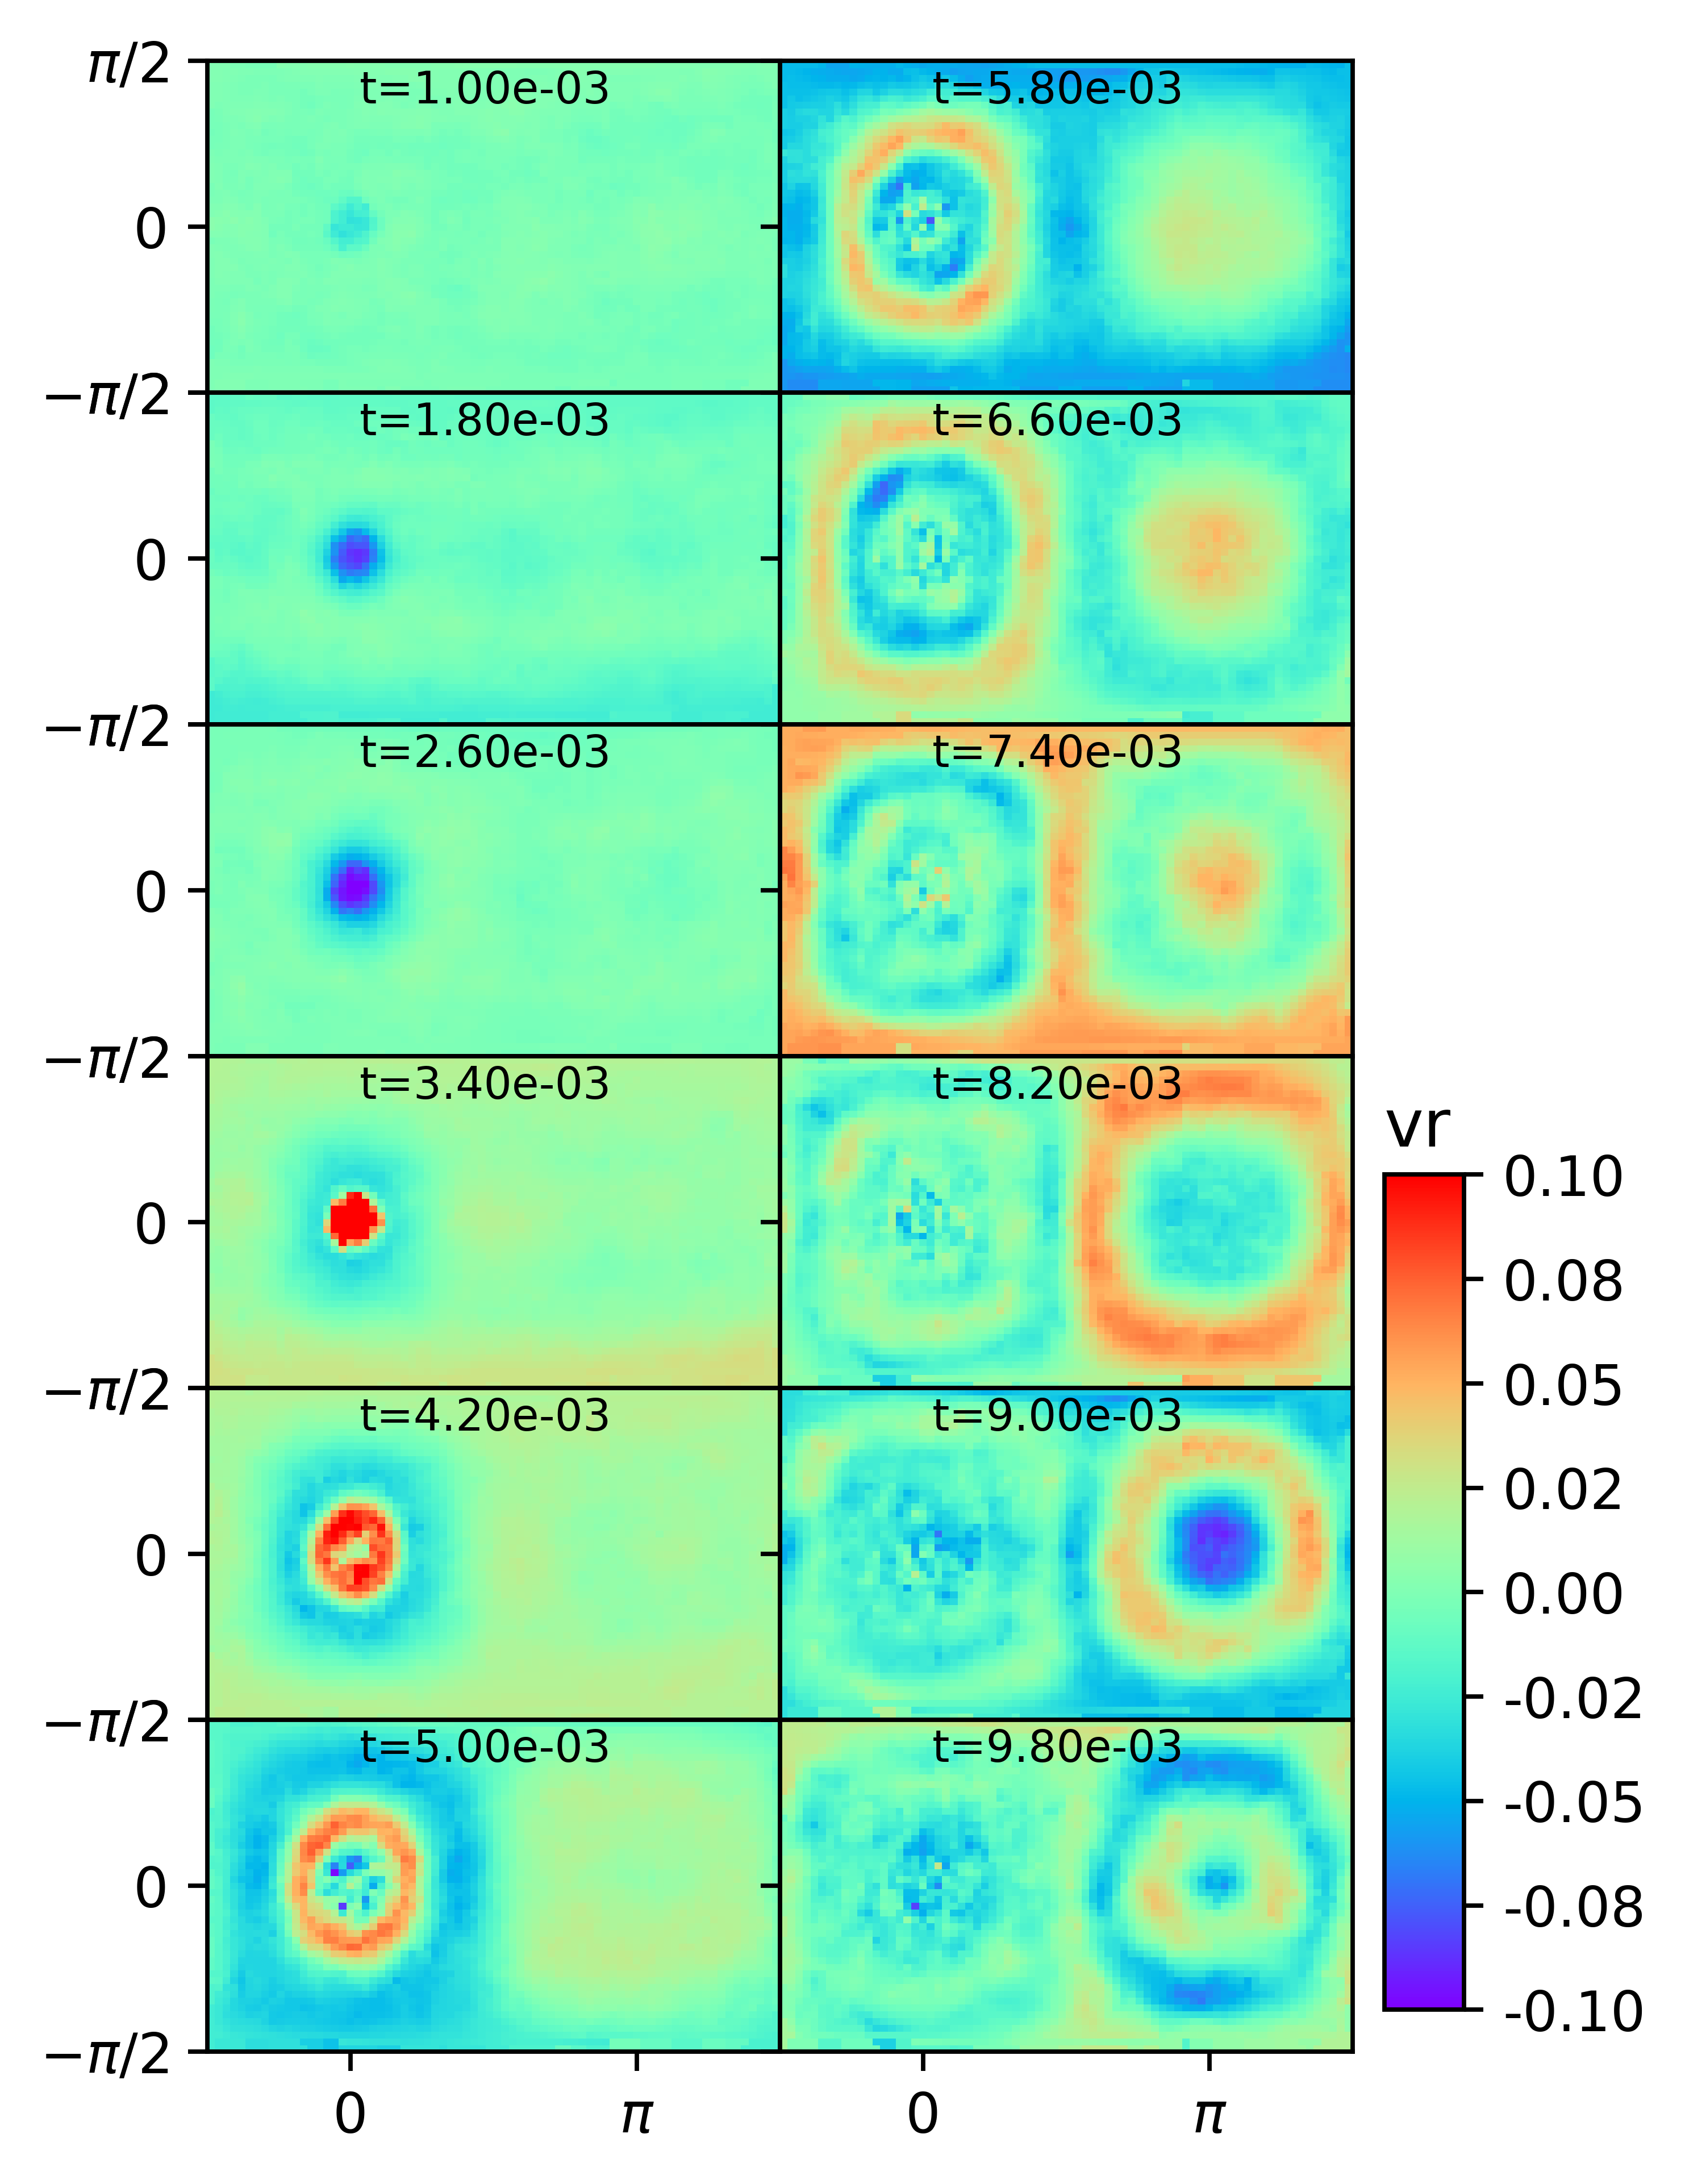

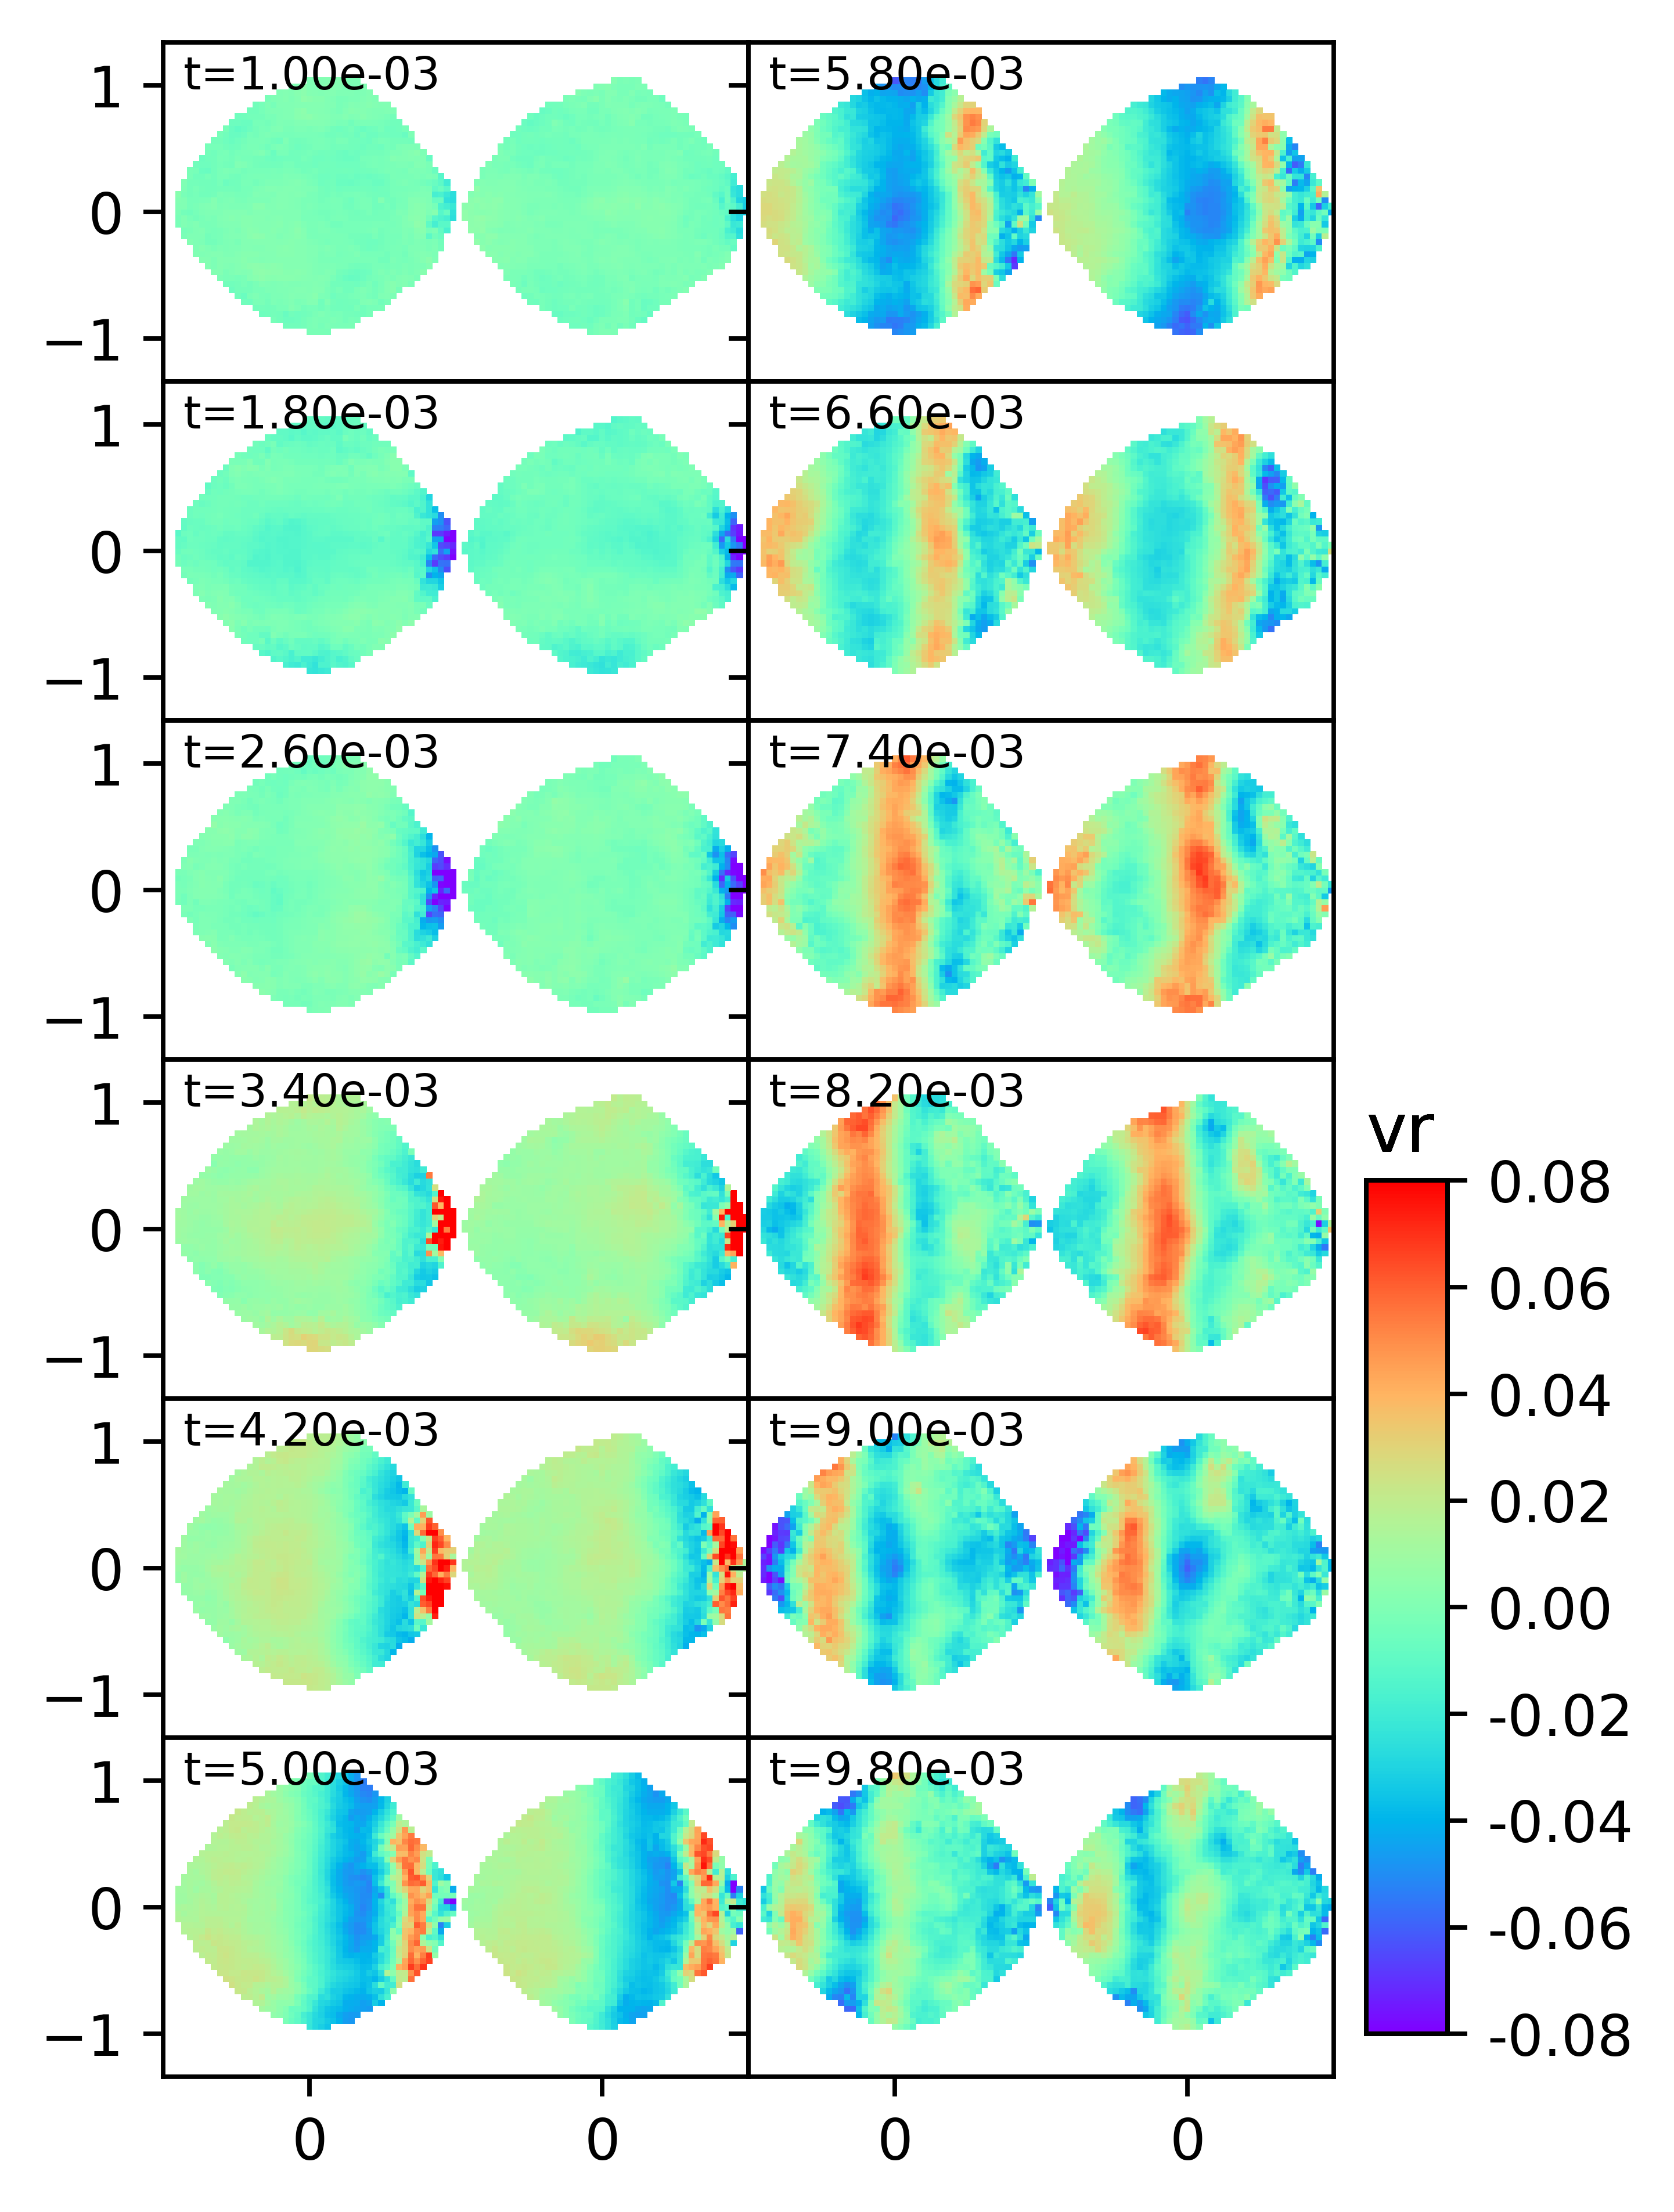

In [134]:

# make some postage stamps
fileroot = "../bennu2/b1_out/b1_surf"  
zmax =0.1
mkpngs_cyl_post(fileroot,10,8,-zmax, zmax, 'vr','b1cylpost.png')  # 
zmax =0.08
mkpngs_orth_post(fileroot,10,8,-zmax, zmax, 'vr','b1orthpost.png')  # 

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
//anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


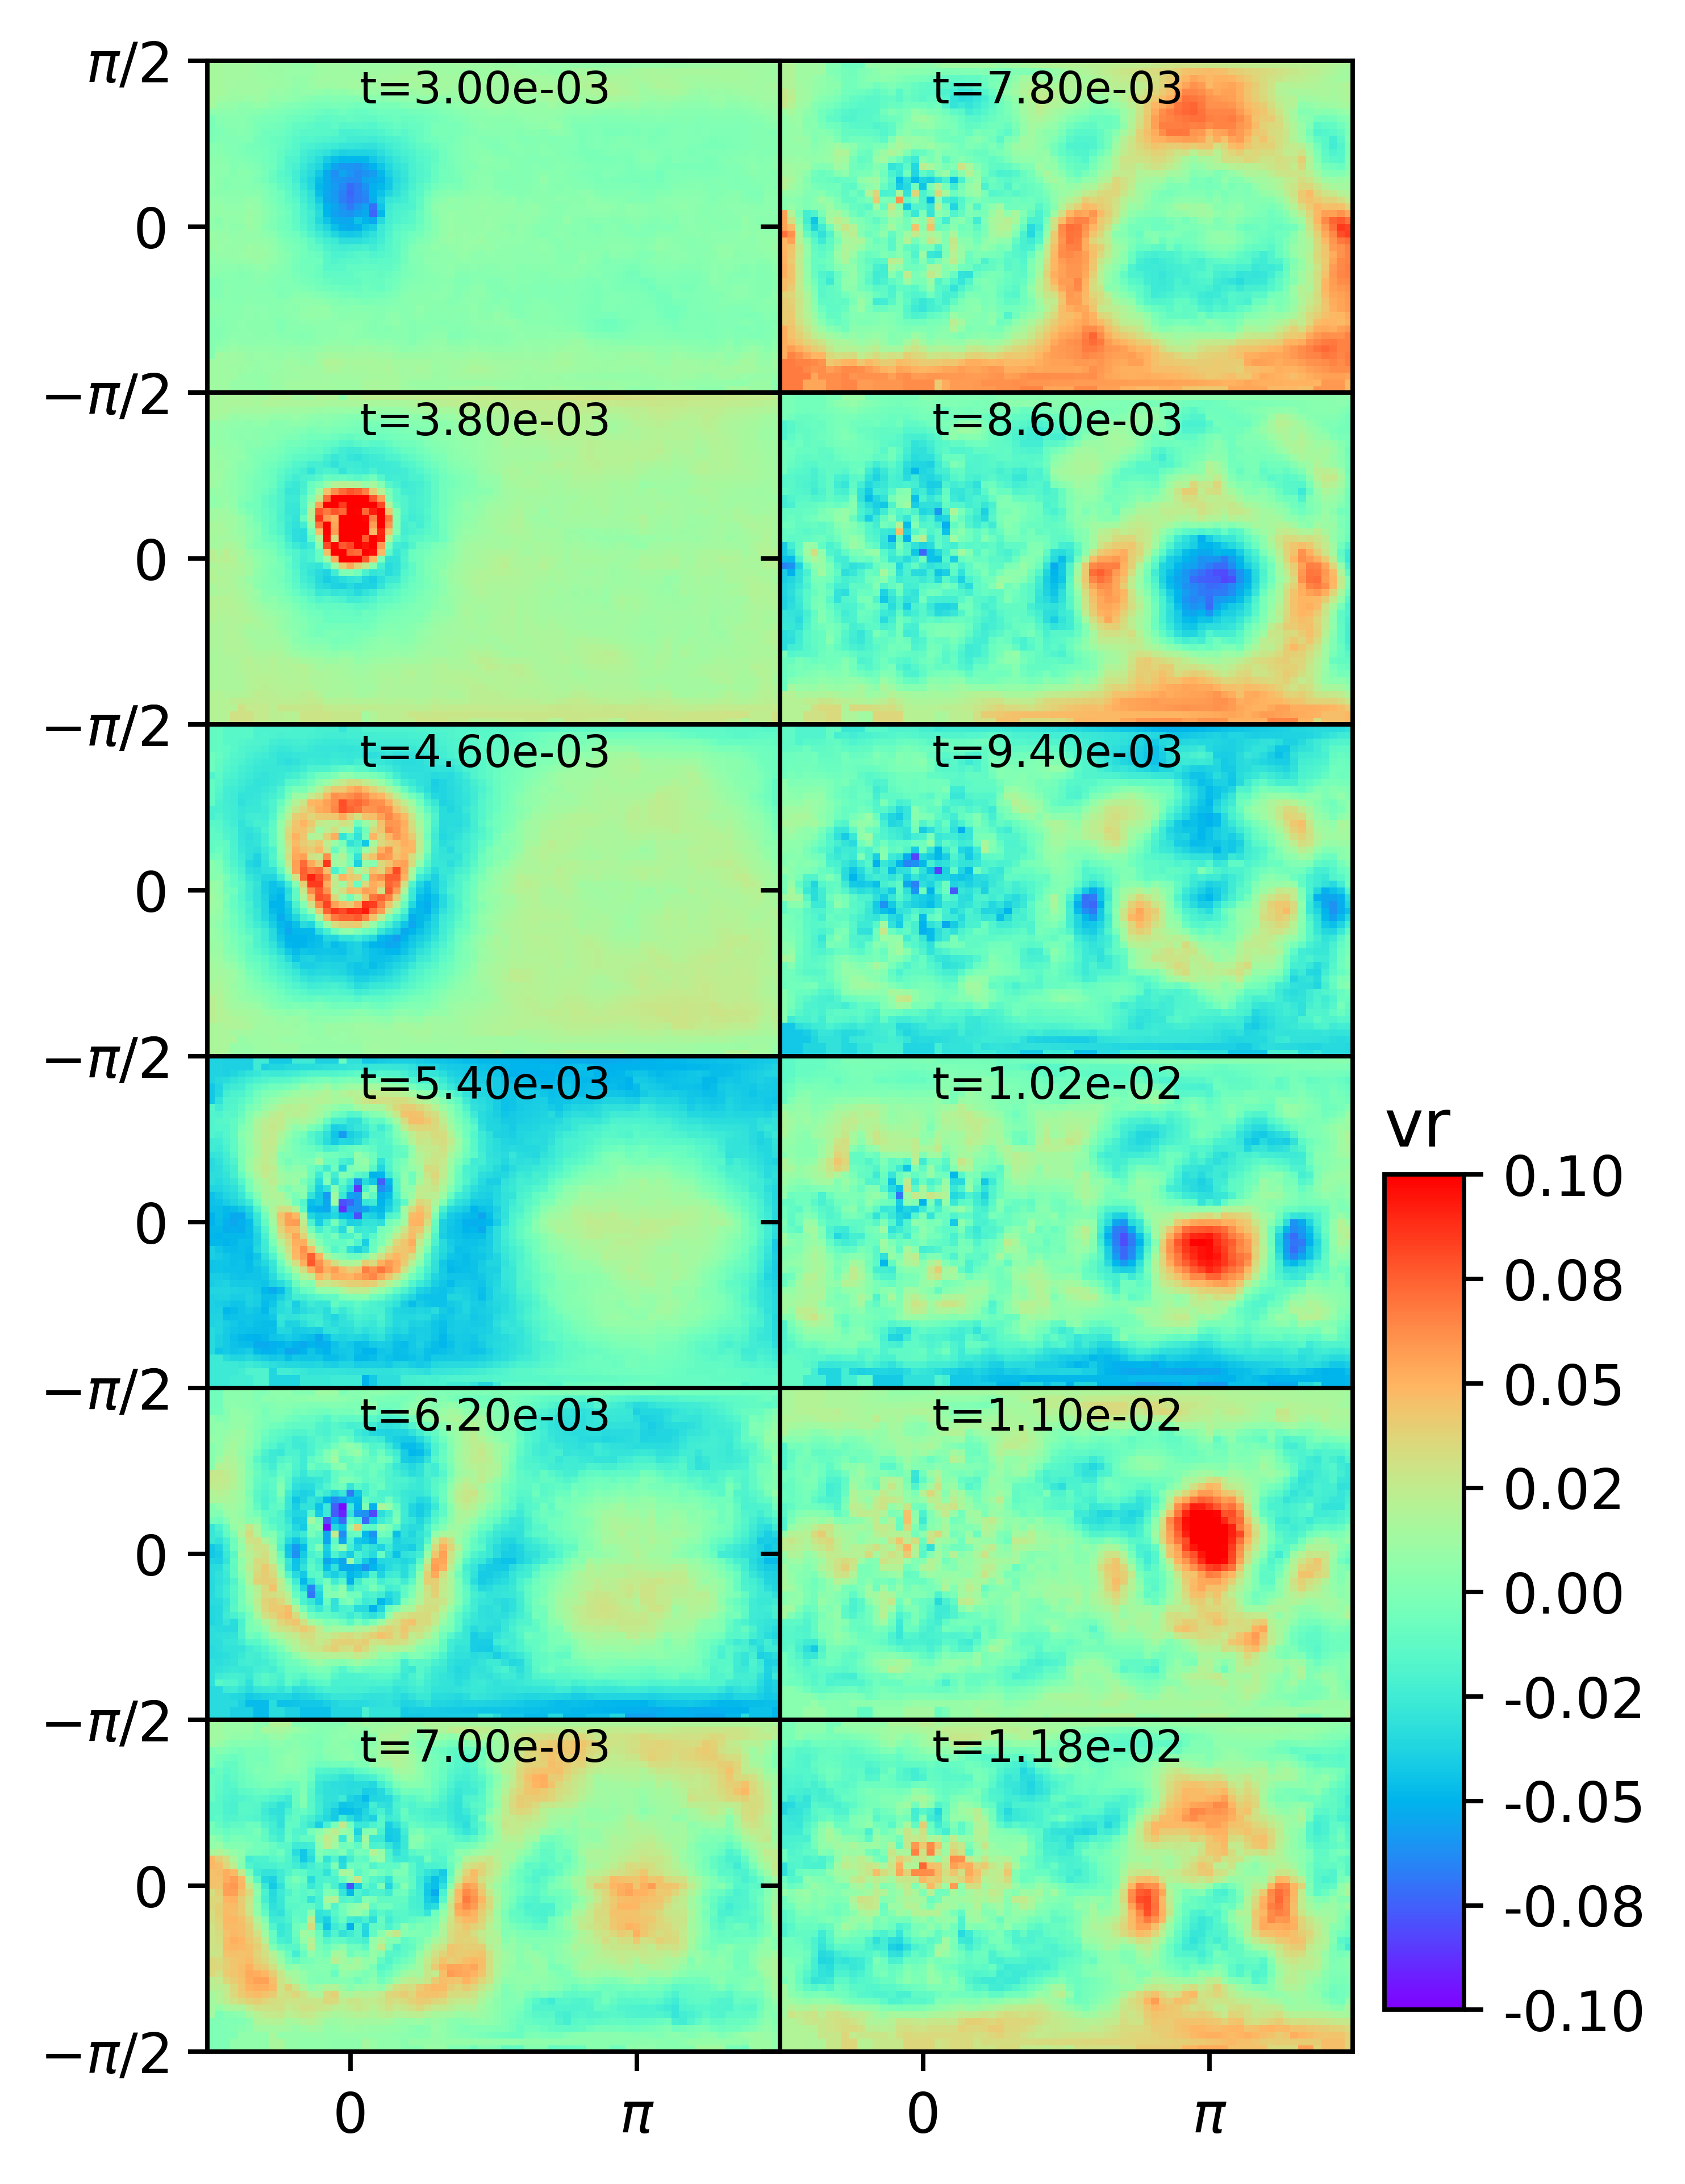

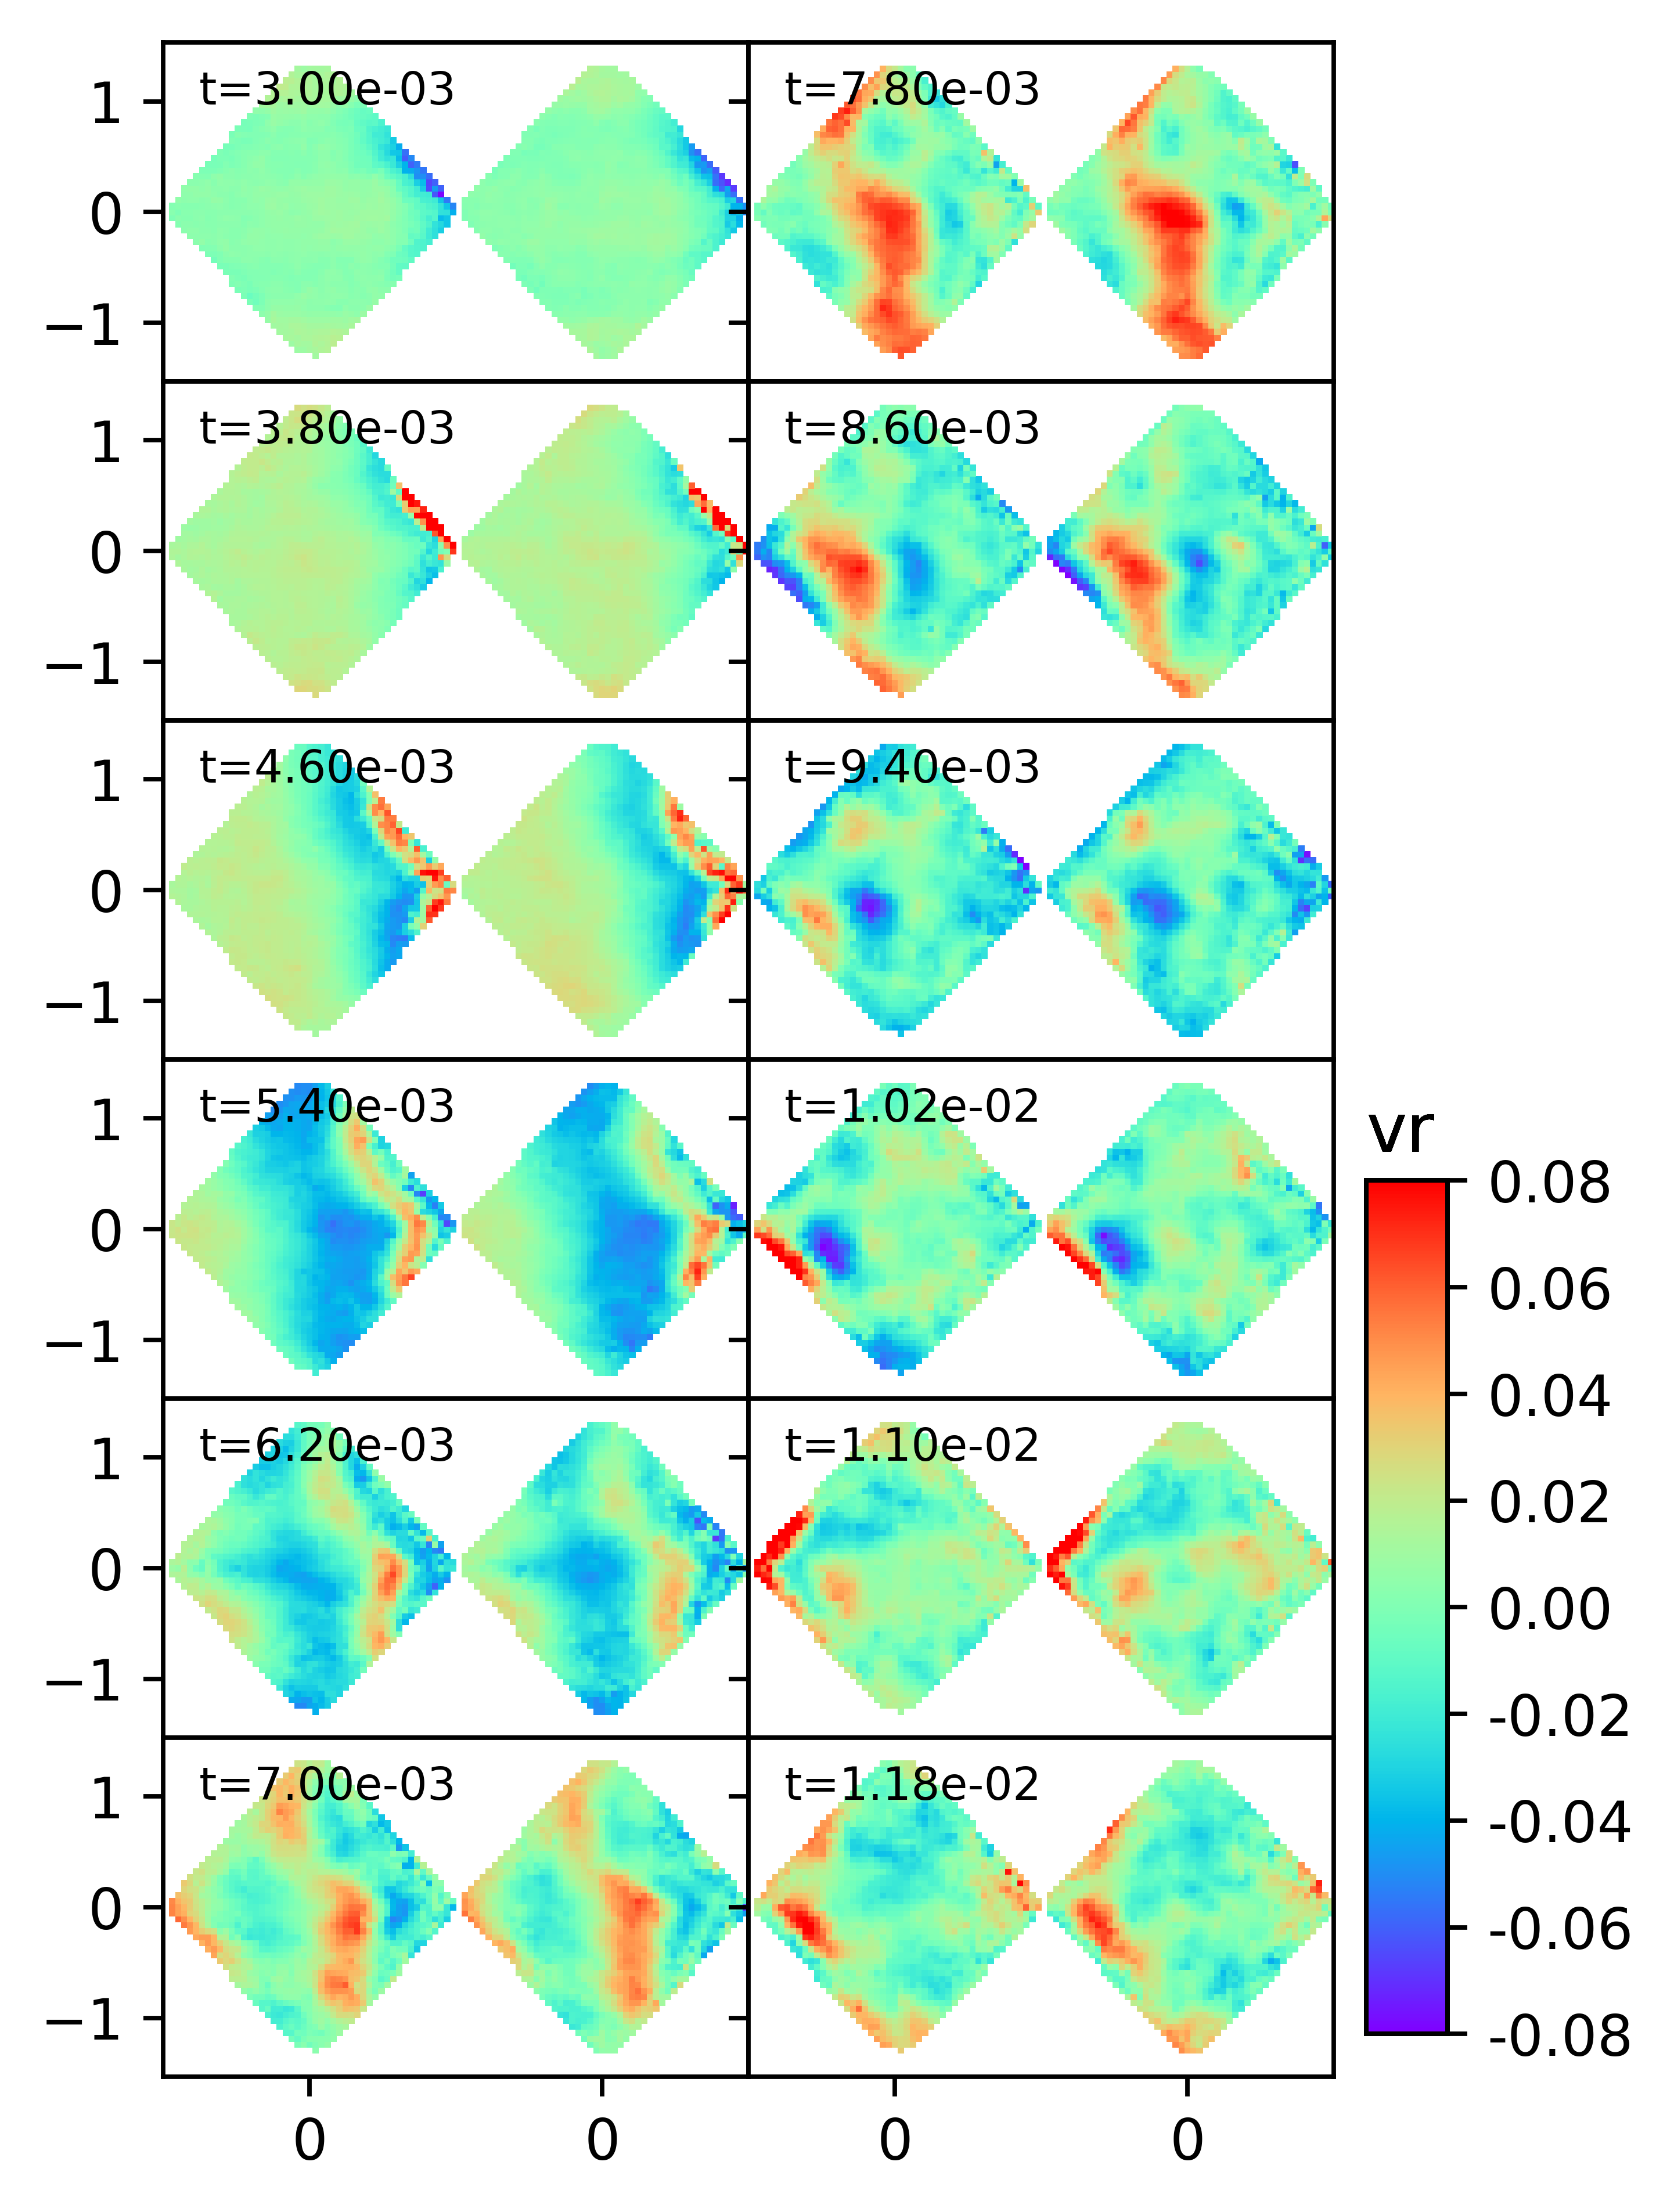

In [133]:
# make some postage stamps
fileroot = "../bennu2/c2_out/c2_surf"  
zmax =0.1
mkpngs_cyl_post(fileroot,30,8,-zmax, zmax, 'vr','c2cylpost.png')  # 
zmax =0.08
mkpngs_orth_post(fileroot,30,8,-zmax, zmax, 'vr','c2orthpost.png')  # 

In [116]:
# find a particle at desired position lat long
fileroot = "../bennu2/b1_out/b1_surf"
lat_deg = 0.0
lon_deg=0.0
npi=1
k = nearest_latlon(fileroot,npi,lat_deg,lon_deg)
print("p", k, " to ", k+2)  # then I extracted this file using dolist.bat
lat_deg =45.0
lon_deg=90.0
npi=1
k = nearest_latlon(fileroot,npi,lat_deg,lon_deg)
print("p", k, " to ", k+2)  # then I extracted this file using dolist.bat
# these are indices in the arrays
# but not line numbers
# you need to add 2 in dolist.bat


p 674  to  676
p 992  to  994


In [119]:
# get some spherical harmonics as a function of time (this takes a while)
fileroot = "../bennu2/b1_out/b1_surf"  
npi=20; npj = 1500  # file index range
m=0;l=0
c1_times,c1_yy00 = sphere_harm_time(fileroot,npi,npj,m,l)
m=2;l=2
c1_times,c1_yy22 = sphere_harm_time(fileroot,npi,npj,m,l)
m=3;l=3
c1_times,c1_yy33 = sphere_harm_time(fileroot,npi,npj,m,l)
m=4;l=4
c1_times,c1_yy44 = sphere_harm_time(fileroot,npi,npj,m,l)
m=5;l=5
c1_times,c1_yy55 = sphere_harm_time(fileroot,npi,npj,m,l)

In [118]:
# get some spherical harmonics as a function of time
#fileroot = "../bennu2/b1_out/b1_surf"  
#npi=20; npj = 1500  # file index range
m=0;l=0
c1_times,c1_yy00 = sphere_harm_time(fileroot,npi,npj,m,l)
m=2;l=2
c1_times,c1_yy22 = sphere_harm_time(fileroot,npi,npj,m,l)
m=3;l=3
c1_times,c1_yy33 = sphere_harm_time(fileroot,npi,npj,m,l)
m=4;l=4
c1_times,c1_yy44 = sphere_harm_time(fileroot,npi,npj,m,l)
m=5;l=5
c1_times,c1_yy55 = sphere_harm_time(fileroot,npi,npj,m,l)

# take spectra of sperical harmonics
istart=40
c1_fsamp,c1_yy00_pows=pos_spec(c1_times[istart:],c1_yy00[istart:])
c1_fsamp,c1_yy22_pows=pos_spec(c1_times[istart:],c1_yy22[istart:])
c1_fsamp,c1_yy33_pows=pos_spec(c1_times[istart:],c1_yy33[istart:])
c1_fsamp,c1_yy44_pows=pos_spec(c1_times[istart:],c1_yy44[istart:])
c1_fsamp,c1_yy55_pows=pos_spec(c1_times[istart:],c1_yy55[istart:])

imax =np.argmax(c1_yy00_pows); c1_00_fmax = c1_fsamp[imax]
imax =np.argmax(c1_yy22_pows); c1_22_fmax = c1_fsamp[imax]
imax =np.argmax(c1_yy33_pows); c1_33_fmax = c1_fsamp[imax]
imax =np.argmax(c1_yy44_pows); c1_44_fmax = c1_fsamp[imax]
imax =np.argmax(c1_yy55_pows); c1_55_fmax = c1_fsamp[imax]
print("00 fmax=",c1_00_fmax)
print("22 fmax=",c1_22_fmax)
print("33 fmax=",c1_33_fmax)
print("44 fmax=",c1_44_fmax)
print("55 fmax=",c1_55_fmax)


00 fmax= 277.777777778
22 fmax= 159.722222222
33 fmax= 236.111111111
44 fmax= 298.611111111
55 fmax= 347.222222222


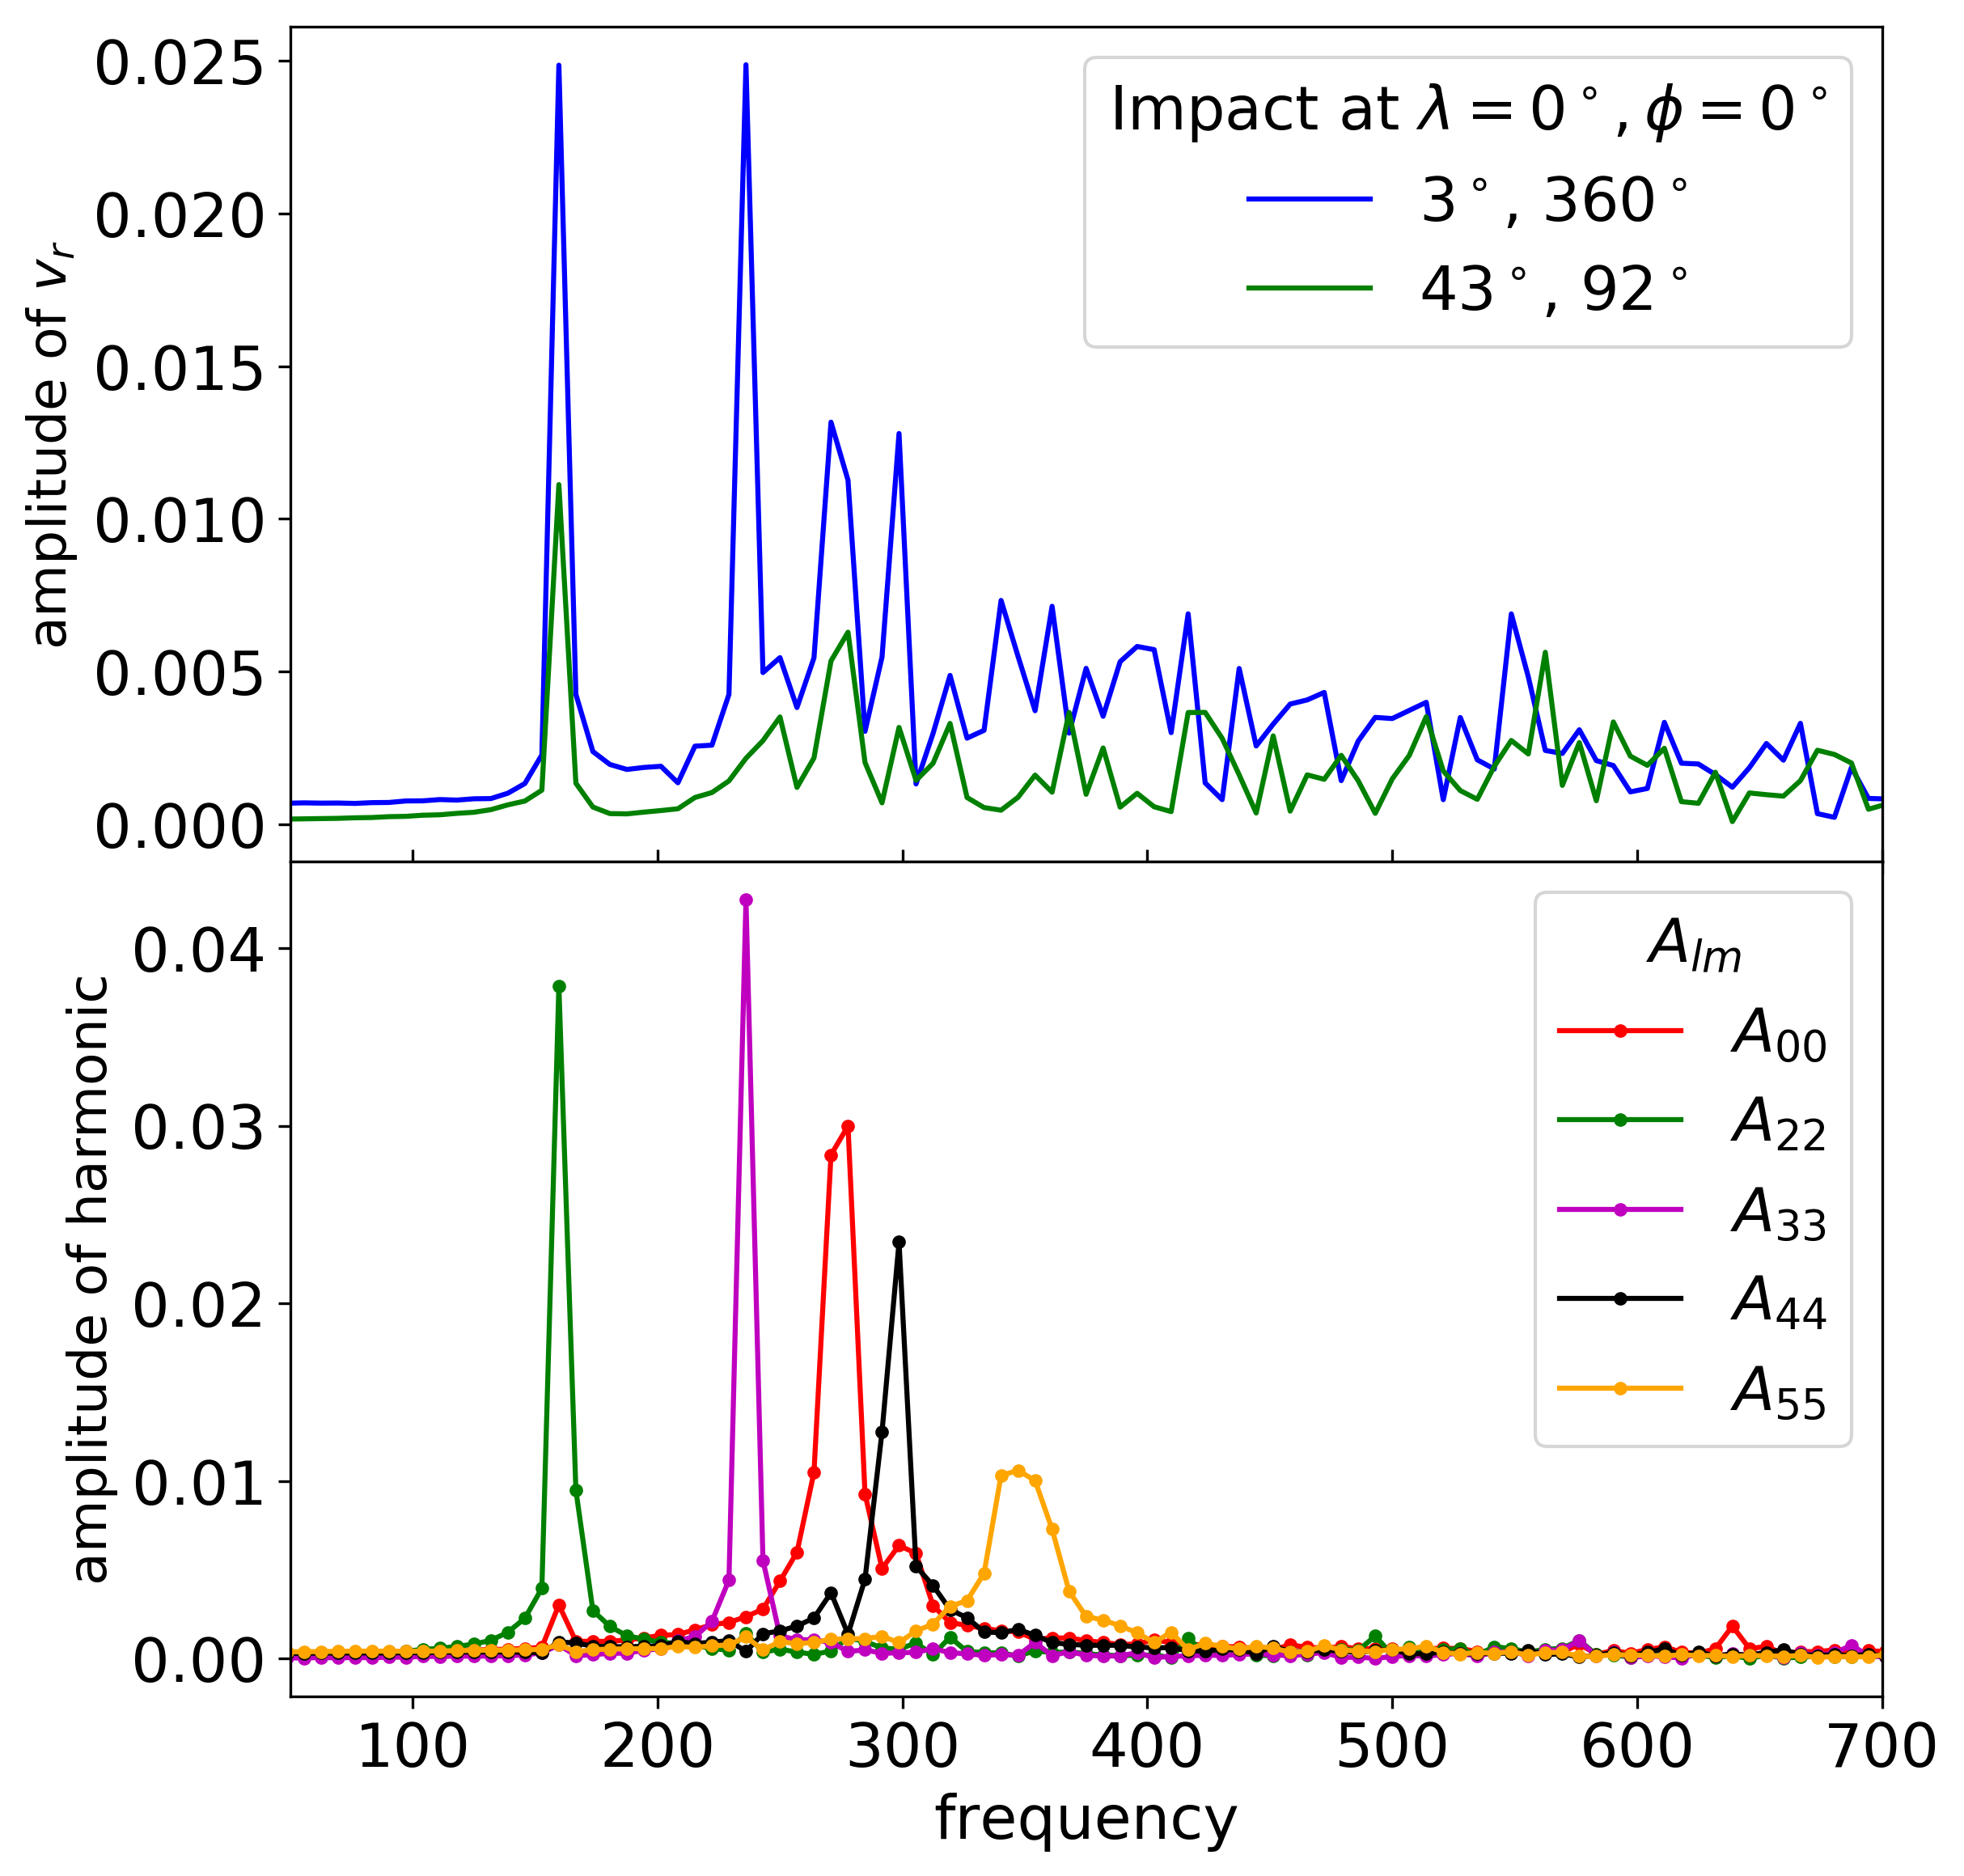

In [120]:
p1name = "../bennu2/b1_out/b1_pa.txt"
p2name = "../bennu2/b1_out/b1_pb.txt"
fsamp = c1_fsamp
yy00_pows = c1_yy00_pows
yy22_pows = c1_yy22_pows
yy33_pows = c1_yy33_pows
yy44_pows = c1_yy44_pows
yy55_pows = c1_yy55_pows
btitle = r'Impact at $\lambda=0^\circ,\phi=0^\circ$';  ofile = 'b1spec.png'
pltspec2p(p1name,p2name,fsamp,yy00_pows,yy22_pows,yy33_pows,yy44_pows,yy55_pows,btitle,ofile)
   

In [28]:
#checking accels
fileroot = "../bennu/c1_out/c1_surf"  
mkpngs_orth(fileroot,10,15,30.1,'ar')  # ar gives accelerations!
mkpngs_orth(fileroot,30,35,30.1,'ar') 
mkpngs_orth(fileroot,100,101,30.1,'ar')  
mkpngs_cyl(fileroot,10,15,30.1,'ar')  # 
mkpngs_cyl(fileroot,30,35,30.1,'ar')  #
mkpngs_cyl(fileroot,100,101,30.1,'ar')  #


//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


In [29]:
mkpngs_orth(fileroot,10,15,0.05,'vr')  # 
mkpngs_orth(fileroot,30,35,0.05,'vr')  # 
mkpngs_orth(fileroot,100,101,0.05,'vr') 
mkpngs_cyl(fileroot,10,15,0.05,'vr')  # 
mkpngs_cyl(fileroot,30,35,0.05,'vr')  # 
mkpngs_cyl(fileroot,100,101,0.05,'vr') 

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]
